In [1]:
DATA_DIR = '/storage/groups/ml01/workspace/louis.kuemmerle/projects/A1/data2/'
DATA_VERSION = 'march22'

In [2]:
import os 
import numpy as np
import scipy as sci
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as pl

import scanpy as sc
import anndata as ann

from scipy.sparse import csr_matrix
from matplotlib import rcParams
from matplotlib import colors


sc.settings.verbosity = 3
sc.logging.print_versions()

-----
anndata     0.7.5
scanpy      1.6.1
sinfo       0.3.1
-----
PIL                 8.1.0
anndata             0.7.5
anyio               NA
attr                20.3.0
babel               2.9.0
backcall            0.2.0
brotli              1.0.9
certifi             2020.12.05
cffi                1.14.4
chardet             4.0.0
cloudpickle         1.6.0
constants           NA
cycler              0.10.0
cython_runtime      NA
dask                2020.12.0
dateutil            2.8.1
decorator           4.4.2
future_fstrings     NA
get_version         2.1
google              NA
h5py                2.10.0
highs_wrapper       NA
idna                2.10
igraph              0.8.3
ipykernel           5.4.3
ipython_genutils    0.2.0
ipywidgets          7.6.3
jedi                0.18.0
jinja2              2.11.2
joblib              1.0.0
json5               NA
jsonschema          3.2.0
jupyter_server      1.2.1
jupyterlab_server   2.1.2
kiwisolver          1.3.1
legacy_api_wrap     1.2
leidenalg

In [3]:
sc.settings.set_figure_params(dpi=70)
sc.settings.verbosity = 3
sc.settings.n_jobs = 3
sc.set_figure_params(vector_friendly=True,color_map='viridis',dpi_save=600,transparent=True)

In [4]:
import rpy2.rinterface_lib.callbacks
import logging

from rpy2.robjects import pandas2ri
import anndata2ri

dirname: Trying to get version of anndata2ri from dirname /opt/python/lib/python3.8/site-packages
dirname: Failed; Does not match re.compile('anndata2ri-([\\d.]+?)(?:\\.dev(\\d+))?(?:[_+-]([0-9a-zA-Z.]+))?$')
git: Trying to get version from git in directory /opt/python/lib/python3.8/site-packages
git: Failed; directory is not managed by git
metadata: Trying to get version for anndata2ri in dir /opt/python/lib/python3.8/site-packages
metadata: Succeeded


In [5]:
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

# Introduction

In this notebook, we preprocess the human skull data. 

We perform the following steps:
1. Load the data
2. Normalize with scran
3. (Examine batch effects - situation on 3.3.22: we only have 1 batch)
4. Save to file 

The following dictionary is extracted from the sample table and contains the origin of each sample (*i.e.* skull, pelvis, femur etc.) and the corresponding condition (MACO, Naive).

# Read the data

In [6]:
adata_tmp = sc.read(DATA_DIR+f'human_tmp_{DATA_VERSION}.h5ad')

In [7]:
adata = sc.read(DATA_DIR+f'human_adata_counts_postQC_{DATA_VERSION}.h5ad')

Show content of the `anndata` objects.

In [8]:
adata

AnnData object with n_obs × n_vars = 4527 × 21044
    obs: 'region', 'organism', 'sample', 'condition', 'n_counts', 'log_counts', 'n_genes', 'mt_fraction'
    var: 'ensemble_id', 'n_cells'
    uns: 'sample_colors'

In [9]:
adata_tmp

AnnData object with n_obs × n_vars = 4527 × 21044
    obs: 'region', 'organism', 'sample', 'condition', 'n_counts', 'log_counts', 'n_genes', 'mt_fraction', 'doublet_score', 'doublet', 'leiden'
    var: 'ensemble_id', 'n_cells'
    uns: 'leiden', 'leiden_colors', 'neighbors', 'pca', 'sample_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

# Normalisation

We perform the normalisation jointly on all data. We already computed a leiden clustering in the preprocessing notebook. 

In [10]:
%%R
#change libPaths
.libPaths(.libPaths()[c(2,1)])

# Load all the R libraries we will be using in the notebook
library(scran)

Before running scran, we have to check whether all clusters are large enough to estimate a size factor. 

In [11]:
adata_tmp.obs['leiden'].value_counts()

0    1171
1     765
2     584
3     528
4     432
5     390
6     175
7     174
8     174
9     134
Name: leiden, dtype: int64

We don't observe clusters with less than 100 cells. Therefore we don't need to merge clusters

In [12]:
adata_tmp.obs['groups'] = adata_tmp.obs['leiden']
#adata_tmp.obs['groups'][adata_tmp.obs['leiden']=='29'] = '21'
adata_tmp.obs['groups'] = adata_tmp.obs['groups'].cat.remove_unused_categories()

## Run scran normalisation for all samples

In [13]:
#Preprocess variables for scran normalization
input_groups = adata_tmp.obs['groups']
data_mat = adata_tmp.X.T

In [14]:
%%R -i data_mat -i input_groups -o size_factors

# For Bioc version <= 3.10
#size_factors = computeSumFactors(data_mat, clusters=input_groups, min.mean=0.1)
# For Bioc version = 3.11
size_factors = computeSumFactors(SingleCellExperiment::SingleCellExperiment(list(counts=data_mat)), clusters =input_groups, min.mean=0.1)

/opt/python/lib/python3.8/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


Assign size factors to original data set collection.

In [15]:
# For Bioc version = 3.11
size_factors = size_factors.obs.sizeFactor.values

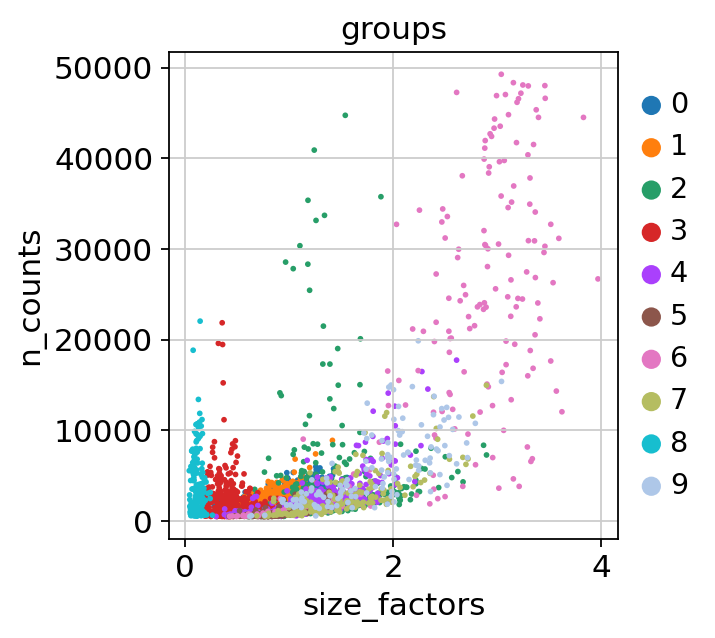

/opt/python/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


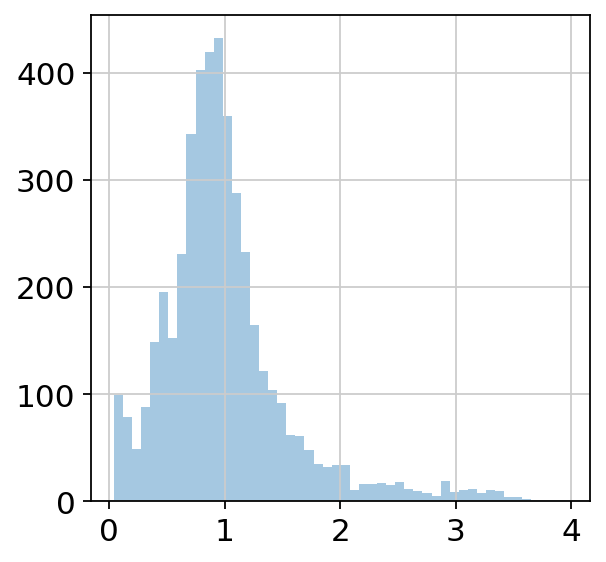

In [16]:
# Visualize the estimated size factors
adata_tmp.obs['size_factors'] = size_factors

sc.pl.scatter(adata_tmp, 'size_factors', 'n_counts', color='groups')

sb.distplot(size_factors, bins=50, kde=False)
pl.show()

## Scale data with size factors

In [17]:
adata.obs['size_factors'] = adata_tmp.obs['size_factors']

In [18]:
adata

AnnData object with n_obs × n_vars = 4527 × 21044
    obs: 'region', 'organism', 'sample', 'condition', 'n_counts', 'log_counts', 'n_genes', 'mt_fraction', 'size_factors'
    var: 'ensemble_id', 'n_cells'
    uns: 'sample_colors'

In [19]:
#Normalize adata 
adata.X /= adata.obs['size_factors'].values[:,None]
sc.pp.log1p(adata)

In [20]:
adata

AnnData object with n_obs × n_vars = 4527 × 21044
    obs: 'region', 'organism', 'sample', 'condition', 'n_counts', 'log_counts', 'n_genes', 'mt_fraction', 'size_factors'
    var: 'ensemble_id', 'n_cells'
    uns: 'sample_colors', 'log1p'

## Save to file

In [21]:
sc.write(adata=adata, filename=DATA_DIR+f'human_data_norm_{DATA_VERSION}.h5ad')